<h1> Pre-processing Reviews and Rating <h1>

<h3> Import libraries</h3>

In [1]:

import nltk

import numpy as np
import pandas as pd
import glob, csv
import re
import string
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import time
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.corpus.reader.wordnet import VERB, NOUN, ADJ, ADV
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from string import punctuation
from string import digits
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV,train_test_split,RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from textblob import TextBlob 
from textblob import Word
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

<h3> Load dataset into dataframes </h3>

In [2]:
raw_interactions  = pd.read_csv('RAW_interactions.csv',index_col=0)# read csv into ratings_df dataframe
raw_interactions.shape

(1132367, 4)

In [3]:
interactions_train=pd.read_csv('interactions_train.csv',index_col=0)
interactions_train.shape
interactions_train.head()

,recipe_id,date,rating,u,i
user_id,,,,,
2046,4684,2000-02-25,5.0,22095,44367
2046,517,2000-02-25,5.0,22095,87844
1773,7435,2000-03-13,5.0,24732,138181
1773,278,2000-03-13,4.0,24732,93054
2046,3431,2000-04-07,5.0,22095,101723


In [4]:
interactions_test=pd.read_csv('interactions_test.csv',index_col=0)
interactions_test.shape
interactions_test.head()

,recipe_id,date,rating,u,i
user_id,,,,,
8937,44551,2005-12-23,4.0,2,173538
56680,126118,2006-10-07,4.0,16,177847
349752,219596,2008-04-12,0.0,26,89896
628951,82783,2007-11-13,2.0,45,172637
92816,435013,2013-07-31,3.0,52,177935


In [10]:
frames = [interactions_train, interactions_test]
interactions_comb=pd.concat(frames)
interactions_comb.shape

(711356, 5)

<h3> Analyze dataset </h3>

Let's see a bar chart of the rating distribution <br/>
<b> Training set distribution </b>

<AxesSubplot:ylabel='rating'>

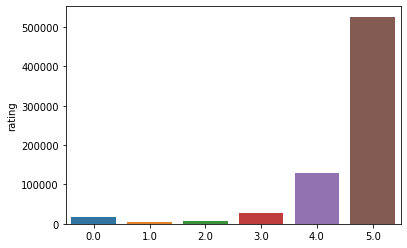

In [11]:

sns.barplot(x=interactions_comb.rating.value_counts().index, y=interactions_comb.rating.value_counts())

Let us take a closer look at reviews with rating 0

In [7]:
raw_interactions.loc[raw_interactions['rating'] == 0].head(7)

,recipe_id,date,rating,review
user_id,,,,
124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo..."
468945,134728,2008-02-20,0,Made my own buttermilk w/ vinegar and milk. U...
681408,225241,2008-03-14,0,This is a very good recipe. We also want to c...
2002068522,29093,2018-03-26,0,i made it and it was amazing
980899,79222,2010-10-18,0,"I used half cream and half 1% milk, added anot..."
1874846,79222,2011-04-04,0,FABULOUS!<br/><br/>I could not afford any of t...
1802697284,79222,2014-11-16,0,Awesome chowder! I used both canned and imitat...


The reviews seem to be positive, but why are the rated 0. Let's build a word cloud and see the top words in the reviews with 0 rating

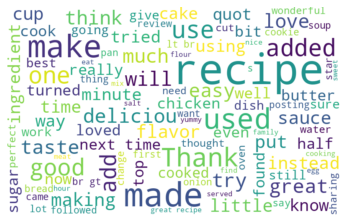

In [8]:
raw_zero_ratings=raw_interactions.loc[raw_interactions['rating'] == 0]
txt = ' '.join(review for review in raw_zero_ratings.review)

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

<b> From the wordcloud its clear that reviews with 0 ratings are reviews with missing ratings</b><br/>
    Therefore, we will build a multi-classification model to predict the missing ratings.
    The reviews with ratings other than 0 will be used as training set to predict ratings for reviews with 0 rating.

<h3> Creating Training and Validation set </h3>

The complete dataset has 1132367 records. We will only take a sample of 20000 records to determine the best classification model. Later, we will train the best model on the whole dataset. We will use <b> GridSearch CV </b> for hyper parameter tuning.

In [10]:
#interactions  = pd.read_csv('RAW_interactions.csv',index_col=0)# read csv into ratings_df dataframe
data=raw_interactions.sample(20000)
data_df = pd.DataFrame(data)
data_df.head()

,recipe_id,date,rating,review
user_id,,,,
230860,158539,2006-03-06,5,I love this recipe! It is so easy to make and...
282929,156242,2006-02-20,5,I was looking for another way to cook chicken ...
383346,368427,2009-09-24,5,I had a small spaghetti squash. Maybe 2 pound...
242729,225794,2007-05-30,5,I was lucky enough to have some MILO that my g...
179133,168634,2012-12-18,5,I made this for Christmas for a co-worker who ...


<h3> Data Preprocessing </h3>

Preprocessing steps
<ul>
    <li>Stop words removal</li>
    <li> Remove punctuations and HTML tags</li>
    <li> Remove characters less than 2 characters </li>
    <li> Remove digits </li>
    <li> Remove dots between abbreviations (eg: U.S.A-> USA) </li>
    <li> Lemmatization </li>
</ul>

In [5]:
eng_stopwords = set(stopwords.words("english"))
stop_words = stopwords.words('english')
eng_stop_words=list(ENGLISH_STOP_WORDS)
my_stop_words=['make','use','add','sugar','garlic','cup','half','eat',
               'come','butter','this','them','look','minute','recipe','oil','pan','rice','you','salt']
eng_stop_words.extend(my_stop_words)
stopwords_dict = Counter(stop_words)
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def stop_word_rem_and_lemmatization(text):
    lemm_text=[]
    #stop_words_cleaned_text=[word for word in text.split() if word not in stopwords_dict]
    
    
    for word,tag in pos_tag(text.lower().split()):
        lemm_text.append(lemmatizer.lemmatize(word, get_wordnet_pos(tag)))
    lemm_text=[word for word in lemm_text if word not in eng_stop_words]
    return " ".join(lemm_text)

def spell_correct(text):
    spell_correct_text=[TextBlob(word).correct() for word in text.split()]
    return ' '.join(spell_correct_text)

In [6]:
remove_digits = str.maketrans('', '', digits)

def preprocessData(text):
    #Text lemmatization and stop words removal
    sentence=stop_word_rem_and_lemmatization(text)
    #print(sentence)
    
    #sentence=spell_correct(sentence)
    
    #remove dots between abbreviations, U.S.A--> USA
    sentence=re.sub('\.(?!(\S[^. ])|\d)', '', sentence)
    
    #pad punctuations with spaces
    sentence = re.sub('([.,!;"?\'~#()&/{}_<>:|\-\*$])', r' \1 ', sentence)
         
    #remove all characters less than or equal to two characters
    sentence=re.sub(r'\b\w{1,2}\b', '', sentence)
    
    #remove all digits
    #sentence = ''.join([i for i in sentence if not i.isdigit()])
    sentence = sentence.translate(remove_digits)
    
    for ch in punctuation+'*()[]^@+=_/\$%-.,':
        sentence = sentence.replace(ch,'')
    
    #remove multiple whitespaces
    sentence= re.sub(' +', ' ', sentence)
    
    #sentence=re.sub('[^A-Za-z0-9\s]+', '', sentence)
            
    return sentence

In [13]:
data_df["review_preprocessed"] = data_df["review"].apply(lambda x: preprocessData(str(x)))


In [14]:
data_df.head()

,recipe_id,date,rating,review,review_preprocessed
user_id,,,,,
230860,158539,2006-03-06,5,I love this recipe! It is so easy to make and...,love recipe easy absolutely delicious alicia
282929,156242,2006-02-20,5,I was looking for another way to cook chicken ...,way cook chicken liver easy recipe and ingredi...
383346,368427,2009-09-24,5,I had a small spaghetti squash. Maybe 2 pound...,small spaghetti squash maybe pounds cook high ...
242729,225794,2007-05-30,5,I was lucky enough to have some MILO that my g...,lucky milo great swap partner chef flower send...
179133,168634,2012-12-18,5,I made this for Christmas for a co-worker who ...,christmas worker celiac easily rise beautifull...


The below Bar chart was used to determine the top 70 words, and add few of the genric words such as 'recipe','oil','pan','rice', etc. to custom stop word set.

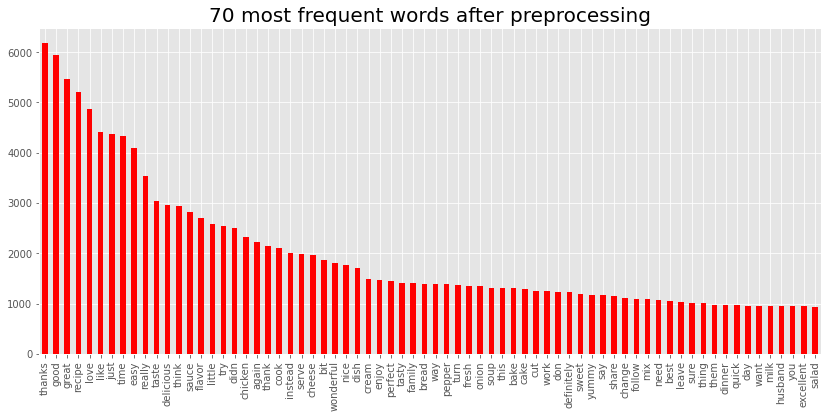

In [15]:
txt = pd.Series(' '.join(review for review in data_df.review_preprocessed).split())

plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=txt.value_counts()[:70]
freq.plot(kind="bar", color = "red")
plt.title("70 most frequent words after preprocessing",size=20)
plt.show()

<h3> Construct Training, Validation and Test sets </h3>
Training/validation (rating_not_zero) set will be all reviews with non-zero ratings, and test set (rating_zero) will be ratings wih zero ratings

In [16]:
rating_not_zero=data_df["rating"]!=0
rating_not_zero=data_df[rating_not_zero]
rating_not_zero.shape

(18933, 5)

In [17]:
rating_zero=data_df["rating"]==0
rating_zero=data_df[rating_zero]
rating_zero.shape

(1067, 5)

In [18]:
# data split 
from sklearn.model_selection import train_test_split 
xtrain, xvalidation, ytrain, yvalidation = train_test_split(rating_not_zero['review_preprocessed'], rating_not_zero['rating'], test_size = 0.3)



<h3> Feature Selection </h3>

We will use TF-IDF for feature selection.

In [19]:


# Convert text to numbers using (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer  

tf_vectorizer = TfidfVectorizer(norm = 'l2',min_df = 0, use_idf = True, smooth_idf = False, sublinear_tf = True,
                             ngram_range=(1,3), max_features = 15000,token_pattern=r'\b\w+\b',analyzer='word')

# let's convert 
xtrain_tf = tf_vectorizer.fit_transform(xtrain).toarray()
xvalidation_tf = tf_vectorizer.transform(xvalidation).toarray()



<h3> Training the model </h3>

<h5> 1. Naive Bayes </h5>

In [23]:
params_NB = {'alpha': [1.0,0.1,0.01,0.01]}
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)
gs_NB = GridSearchCV(estimator=MultinomialNB(), 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')
gs_NB.fit(xtrain_tf,ytrain);
gs_NB.best_params_

Fitting 15 folds for each of 4 candidates, totalling 60 fits


{'alpha': 0.1}

In [39]:
nby = MultinomialNB(alpha=0.1,fit_prior=True, class_prior=None)
nby.fit(xtrain_tf,ytrain)
y_pred=nby.predict(xvalidation_tf)
accuracy=round(accuracy_score(yvalidation, y_pred)*100,2)
precision=round(precision_score(yvalidation, y_pred, average="macro")*100,2)
print("Accuracy: ",accuracy)
print("Precision: ",precision)


model_metrics=pd.DataFrame();
model_metrics['Name']=["Naive Bayes"]
model_metrics['Accuracy']=[accuracy]
model_metrics['Precision']=[precision]
#model_metrics.loc[len(model_metrics.index)] = ["Naive bayes", accuracy, precision]


Accuracy:  76.69
Precision:  75.06


<h5>2. Logistic Regression </h5>

In [49]:
# LRparam_grid = {
#     'C': [0.01, 0.1, 1, 10, 100, 1000],
#     'penalty': ['l2'],
#     'max_iter': [100],
#     'solver': ['newton-cg', 'lbfgs']
# }
# gs_LR = GridSearchCV(estimator=LogisticRegression(), 
#                      param_grid=LRparam_grid, 
#                      cv=cv_method,
#                      verbose=1, 
#                      scoring='accuracy')
# gs_LR.fit(xtrain_tf,ytrain);
# gs_LR.best_params_


In [38]:
lr = LogisticRegression(C=1000,max_iter=100, penalty='l2', solver='newton-cg')
lr.fit(xtrain_tf,ytrain)
predictions_lr = lr.predict(xvalidation_tf)
accuracy=round(accuracy_score(yvalidation, predictions_lr)*100,2)
precision=round(precision_score(yvalidation, predictions_lr, average="macro")*100,2)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
model_metrics.loc[len(model_metrics.index)] = ["Logistic Regression", accuracy, precision]

Accuracy:  73.38
Precision:  47.68


<h5>3. KNN</h5>

In [36]:
# svm = svm.SVC(probability=True, kernel="sigmoid",gamma=1,C=100)
# svm.fit(xtrain_tf,ytrain)
# predictions_svm = svm.predict(xvalidation_tf)
# accuracy=round(accuracy_score(yvalidation, predictions_svm)*100,2)
# precision=round(precision_score(yvalidation, predictions_svm, average="macro")*100,2)
# print("Accuracy of SVM is : :",accuracy)
# print("Precision of SVM is :",precision)
# model_metrics['Name']=["SVM"]
# model_metrics['Accuracy']=[accuracy]
# model_metrics['Precision']=[precision]

knn = KNeighborsClassifier(n_neighbors=10,algorithm='auto',metric='cosine')
knn.fit(xtrain_tf,ytrain)
predictions_knn = knn.predict(xvalidation_tf)
accuracy=round(accuracy_score(yvalidation, predictions_knn)*100,2)
precision=round(precision_score(yvalidation, predictions_knn, average="macro")*100,2)
print("KNN accuracy:",accuracy)
print("KNN precision",precision)

model_metrics.loc[len(model_metrics.index)] = ['KNN', accuracy, precision]

KNN accuracy: 74.93
KNN precision 42.02


<h5>4. Random Forest</h5>

In [32]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42,max_features=2000)
rf.fit(xtrain_tf,ytrain)
predictions_rf = rf.predict(xvalidation_tf)
accuracy=round(accuracy_score(yvalidation, predictions_rf)*100,2)
precision=round(precision_score(yvalidation, predictions_rf, average="macro")*100,2)
print("Accuracy of Random forest is : :",accuracy)
print("Precision of Random Forest is :",precision)
model_metrics['Name']=["Random Forest"]
model_metrics['Accuracy']=[accuracy]
model_metrics['Precision']=[precision]

Accuracy of Random forest is : : 75.56
Precision of Random Forest is : 32.37


/opt/ohpc/pub/apps/python3/3.8.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
model_metrics

,Name,Accuracy,Precision
0,Random Forest,75.56,32.37
1,KNN,74.93,42.02
2,Logistic Regression,73.38,47.68
3,Naive bayes,76.69,75.06


<b> Naive bayes is the model with accuracy</b> We will use it to train the complete dataset and make predictions based on it

<h3> Train complete dataset with Naive Bayes</h3>

In [43]:
complete_data= raw_interactions
complete_data["review_preprocessed"] = complete_traindata["review"].apply(lambda x: preprocessData(str(x)))

In [8]:
complete_data=pd.read_csv('raw_interactions_preprocessed.csv',index_col=0)
complete_data.head()

,recipe_id,date,rating,review,review_preprocessed
user_id,,,,,
38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,great salad cook stove minutes added shake cay...
1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",simple delicious great chilly fall evening dou...
8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,work easy quite package oz white chips great
126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,mexican topping bunko love
57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",cheddar bacon topping sprinkling black pepper ...


In [13]:
rating_not_zero=complete_data["rating"]!=0
complete_trainset=complete_data[rating_not_zero]
ytrain_comp=complete_trainset['rating'].values.astype('U')
complete_trainset=complete_trainset['review_preprocessed'].values.astype('U')

rating_zero=complete_data["rating"]==0
complete_testset=complete_data[rating_zero]
ytest_comp=complete_testset['rating'].values.astype('U')
x_test= complete_testset['review_preprocessed'].values.astype('U')

In [14]:
#complete_data.to_csv("raw_interactions_preprocessed.csv")

In [15]:
tf_vectorizer = TfidfVectorizer(norm = 'l2',min_df = 0, use_idf = True, smooth_idf = False, sublinear_tf = True,
                             ngram_range=(1,3), max_features = 15000,token_pattern=r'\b\w+\b',analyzer='word')

# let's convert 
xtrain_comp = tf_vectorizer.fit_transform(complete_trainset).toarray()
xtest_comp = tf_vectorizer.transform(x_test).toarray()

In [17]:
nby = MultinomialNB(alpha=0.1,fit_prior=True, class_prior=None)
nby.fit(xtrain_comp,ytrain_comp)
predictions=nby.predict(xtest_comp)
#accuracy=round(accuracy_score(yvalidation, y_pred)*100,2)
#precision=round(precision_score(yvalidation, y_pred, average="macro")*100,2)
#print("Accuracy: ",accuracy)
#print("Precision: ",precision)

<h3> Predict using the model </h5>

In [18]:
complete_testset.insert(4,'without_0_rating',predictions.tolist())

In [19]:
complete_testset.head()

,recipe_id,date,rating,review,without_0_rating,review_preprocessed
user_id,,,,,,
124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo...",5,just observation rate follow procedure strawbe...
468945,134728,2008-02-20,0,Made my own buttermilk w/ vinegar and milk. U...,5,buttermilk vinegar milk defrost fresh skinless...
681408,225241,2008-03-14,0,This is a very good recipe. We also want to c...,5,good recipe want cut fat content diet tasty dish
2002068522,29093,2018-03-26,0,i made it and it was amazing,5,amaze
980899,79222,2010-10-18,0,"I used half cream and half 1% milk, added anot...",5,cream milk cream end nutmeg nearly pkg bacon c...


In [20]:
predictions_df = complete_testset.filter(['user_id','recipe_id','without_0_rating'], axis=1)

In [21]:
predictions_df.head()

,recipe_id,without_0_rating
user_id,,
124416,120345,5
468945,134728,5
681408,225241,5
2002068522,29093,5
980899,79222,5


In [22]:
merged_df=  pd.merge(interactions_train, predictions_df,  how='left', left_on=['user_id','recipe_id'], right_on = ['user_id','recipe_id'])

In [23]:
merged_df['without_0_rating']=merged_df['without_0_rating'].fillna(merged_df['rating'])

In [24]:
merged_df.head()

,recipe_id,date,rating,u,i,without_0_rating
user_id,,,,,,
2046,4684,2000-02-25,5.0,22095,44367,5.0
2046,517,2000-02-25,5.0,22095,87844,5.0
1773,7435,2000-03-13,5.0,24732,138181,5.0
1773,278,2000-03-13,4.0,24732,93054,4.0
2046,3431,2000-04-07,5.0,22095,101723,5.0


In [25]:
merged_df['without_0_rating'].value_counts()

5.0    518568
4.0    127402
3.0     25781
5       14942
2.0      6852
1.0      3341
4         876
3         649
1         320
2         170
Name: without_0_rating, dtype: int64

In [26]:
merged_df.to_csv("interactions_train_new.csv", index=True)

In [27]:
merged_df_test=  pd.merge(interactions_test, predictions_df,  how='left', left_on=['user_id','recipe_id'], right_on = ['user_id','recipe_id'])
merged_df_test['without_0_rating']=merged_df_test['without_0_rating'].fillna(merged_df_test['rating'])

In [28]:
merged_df_test.to_csv("interactions_test_new.csv", index=True)